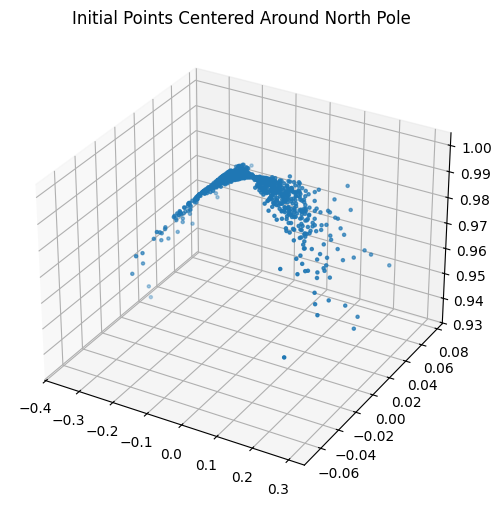

Epoch 0 | Loss: 0.4615
Epoch 100 | Loss: 0.0035
Epoch 200 | Loss: 0.0034
Epoch 300 | Loss: 0.0035
Epoch 400 | Loss: 0.0034
Epoch 500 | Loss: 0.0034
Epoch 600 | Loss: 0.0034
Epoch 700 | Loss: 0.0034
Epoch 800 | Loss: 0.0034
Epoch 900 | Loss: 0.0034


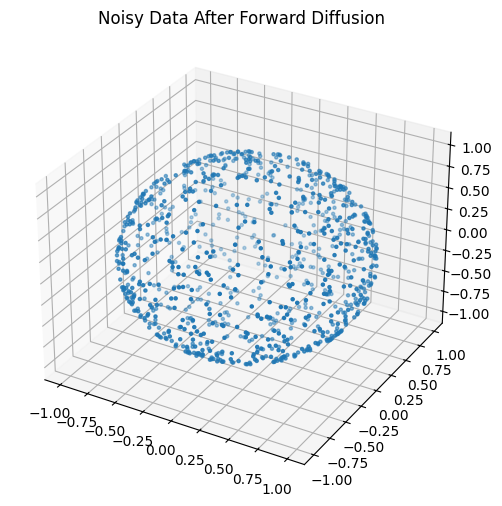

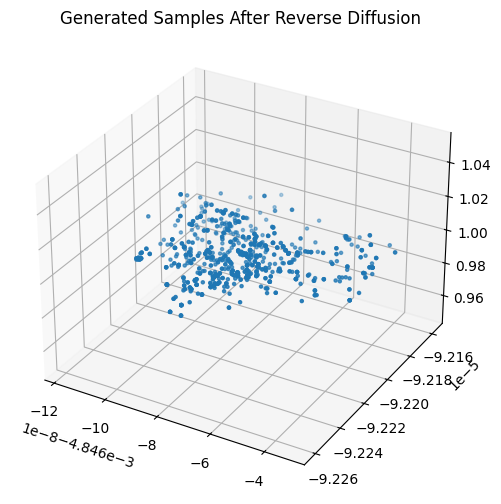

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Utility function: normalize points to lie on a sphere
def normalize_to_sphere(points):
    return points / torch.norm(points, dim=1, keepdim=True)

# Function to generate noisy spherical data (forward diffusion)
def apply_spherical_noise(points, t, noise_scale=0.1):
    noise = torch.randn_like(points) * noise_scale * t.view(-1, 1)  # Reshape t for broadcasting
    noisy_points = points + noise
    noisy_points = normalize_to_sphere(noisy_points)
    return noisy_points

# Diffusion model (denoising network)
class SphericalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SphericalDiffusionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        return self.network(x)

# Loss function for diffusion (score matching)
def diffusion_loss(model, x_0, t, noise_scale=0.1):
    x_t = apply_spherical_noise(x_0, t, noise_scale)
    noise_pred = model(x_t, t)
    actual_noise = x_t - x_0
    loss = torch.mean((noise_pred - actual_noise) ** 2)
    return loss

# Function to sample using reverse diffusion
def reverse_diffusion(model, noisy_data, timesteps, noise_scale=0.1):
    with torch.no_grad():
        for t in reversed(range(timesteps)):
            noise_pred = model(noisy_data, t)
            noisy_data = noisy_data - noise_pred
            noisy_data = normalize_to_sphere(noisy_data)
    return noisy_data

# Training loop for diffusion model
def train_diffusion_model(model, data, timesteps=100, noise_scale=0.1, epochs=1000, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.randint(0, timesteps, (data.shape[0],)).float()
        loss = diffusion_loss(model, data, t, noise_scale)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# Generate initial points on a sphere centered at a specific direction
def generate_sphere_points_centered(num_points, center_direction, spread=0.1):
    center_direction = center_direction / torch.norm(center_direction)
    theta_noise = torch.randn(num_points) * spread
    phi_noise = torch.randn(num_points) * spread
    theta = torch.arccos(center_direction[2]) + theta_noise
    phi = torch.atan2(center_direction[1], center_direction[0]) + phi_noise
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    return torch.stack([x, y, z], dim=1)

# Plotting utility for 3D points on a sphere
def plot_sphere(points, title=""):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    ax.set_title(title)
    plt.show()

# Main code to run the diffusion model and visualize the process
num_points = 1000
center_direction = torch.tensor([0.0, 0.0, 1.0])

# Generate initial data on a sphere centered around the north pole
initial_data = generate_sphere_points_centered(num_points, center_direction, spread=0.1)

# Plot the initial points on the sphere
plot_sphere(initial_data, title="Initial Points Centered Around North Pole")

# Define the diffusion model
input_dim = 3  # 3D space (x, y, z)
hidden_dim = 512
diffusion_model = SphericalDiffusionModel(input_dim, hidden_dim)

# Train the diffusion model on the initial data
train_diffusion_model(diffusion_model, initial_data, timesteps=100, epochs=1000)

# Sample from the model using reverse diffusion
timesteps = 1000
t = torch.full((initial_data.shape[0],), timesteps, dtype=torch.float32)

# Apply forward diffusion (add noise)
noisy_data = apply_spherical_noise(initial_data, t, noise_scale=0.1)
plot_sphere(noisy_data, title="Noisy Data After Forward Diffusion")

# Reverse diffusion process to generate samples
generated_samples = reverse_diffusion(diffusion_model, noisy_data, timesteps)
plot_sphere(generated_samples, title="Generated Samples After Reverse Diffusion")